# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [57]:
# Guess this is a hash of the email for anonymity purposes
df.iloc[0]['email']

'ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7'

In [58]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [59]:
# The interactions are not always unique so we get the total counts
interaction_counts = df.groupby('email')['article_id'].count()

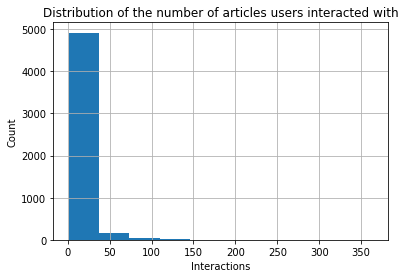

In [60]:
ax = interaction_counts.hist()
_ = ax.set(xlabel='Interactions', ylabel='Count', title='Distribution of the number of articles users interacted with')

In [61]:
# Fill in the median and maximum number of user_article interactios below
median_val = int(interaction_counts.median())  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = int(interaction_counts.max())  # The maximum number of user-article interactions by any 1 user is ______.

print(f'50% of individuals interact with {median_val} number of articles or fewer.')
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


In [62]:
# Look at which users had the most interactions
interaction_counts.sort_values(ascending=False)

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
1b520f0f65c0aee52d4235f92fb2de58fa966635      1
7a67e4a2902a20062e1f2a6835b6e099b34b4f6c      1
c4b7e639e91b1d18e5b9c000f0ad3354888fcdde      1
7a7fb282789944665ffc1cddee5ddbdbd7ca9f64      1
9655144418d25a0e074616840447e6e5dbef0069      1
Name: article_id, Length: 5148, dtype: int64

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [63]:
# Find and explore duplicate articles
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [64]:
# There are 0 full duplicated rows (every column the same)
df_content[df_content.duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id


In [65]:
# However if we just look at the article_id we see a small number of duplicates on this
df_content[df_content.duplicated(subset=['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [66]:
# We can also find these manually w/o using the pandas duplicated method:
article_id_cnts = df_content.groupby('article_id')['article_id'].count()

In [67]:
article_id_cnts[article_id_cnts > 1]

article_id
50     2
221    2
232    2
398    2
577    2
Name: article_id, dtype: int64

In [68]:
# We see that these look similar but have different doc_description for article_id==50
df_content[df_content['article_id'] == 50]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


In [69]:
for col in df_content.columns:
    dups = df_content[df_content.duplicated(subset=[col])]
    dup_count = dups.shape[0]
    print(f'For column {col} we have {dup_count} duplicates')
    # if dup_count:
    #     print(dups)

For column doc_body we have 19 duplicates
For column doc_description we have 33 duplicates
For column doc_full_name we have 5 duplicates
For column doc_status we have 1055 duplicates
For column article_id we have 5 duplicates


We expect duplicates for things like `doc_status` and others but definitely not `article_id`.

In [70]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'])

In [71]:
# Check that now we have no duplicates
assert df_content[df_content.duplicated(subset=['article_id'])].shape[0] == 0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [72]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [73]:
df.article_id.nunique()

714

In [74]:
df_content.shape[0]

1051

In [75]:
df.email.nunique()

5148

In [76]:
df.shape[0]

45993

In [77]:
unique_articles =  int(df.article_id.nunique())   # The number of unique articles that have at least one interaction
total_articles = int(df_content.shape[0])  # The number of unique articles on the IBM platform
unique_users = int(df.email.nunique()) # The number of unique users
user_article_interactions =  int(df.shape[0])  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [78]:
df.groupby('article_id')['email'].count().sort_values(ascending=False).index[0]

1429.0

In [79]:
df[df['article_id'] == 1429]

,article_id,title,email
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
41,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
75,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
80,1429.0,use deep learning for image classification,d385b6c44711688ce2a33eb596495bf9243e1750
...,...,...,...
45147,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45153,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45156,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45190,1429.0,use deep learning for image classification,7aef8f14001f95da4a76c810970d4aa469cdf11f


In [80]:
df.groupby('article_id')['email'].count().sort_values(ascending=False).iloc[0]

937

In [81]:
most_viewed_article_id = str(df.groupby('article_id')['email'].count().sort_values(ascending=False).index[0])  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = int(df.groupby('article_id')['email'].count().sort_values(ascending=False).iloc[0])  # The most viewed article in the dataset was viewed how many times?

In [82]:
most_viewed_article_id

'1429.0'

In [83]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [84]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [85]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [86]:
df.groupby('article_id')['user_id'].count()

article_id
0.0       14
2.0       58
4.0       13
8.0       85
9.0       10
          ..
1440.0    10
1441.0     8
1442.0     4
1443.0    22
1444.0     5
Name: user_id, Length: 714, dtype: int64

In [42]:
list(df[df.article_id.isin([0, 2])].groupby('article_id').first()['title'])

['detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)']

In [87]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_article_ids = get_top_article_ids(n, df=df)
    top_articles = list(df[df.article_id.isin(top_article_ids)].groupby('article_id').first()['title'])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_article_ids = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).iloc[:n].index

    return top_article_ids # Return the top article ids

In [88]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'finding optimal locations of new store using decision optimization', 'gosales transactions for logistic regression model', 'healthcare python streaming application demo', 'insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'use deep learning for image classification', 'visualize car data with brunel']
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64', name='article_id')


In [45]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [47]:
df[df.user_id==1].sort_values(by=['article_id']).head()

,article_id,title,user_id
1710,43.0,deep learning with tensorflow course by big da...,1
1712,109.0,tensorflow quick tips,1
11083,151.0,jupyter notebook tutorial,1
20322,268.0,sector correlations shiny app,1
3839,310.0,time series prediction using recurrent neural ...,1


In [256]:
df.groupby(['user_id', 'article_id']).count().unstack().notnull()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1           False  False  False  False  False  False  False  False  False   
2           False  False  False  False  False  False  False  False  False   
3           False  False  False  False  False   True  False  False  False   
4           False  False  False  False  False  False  False  False  False   
5           False  False  False  False  False  False  False  False  False   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
5145        False  False  False  False  False  False  False  False  False   
5146        False  False  False  False  False  False  False  False  False   
5147        False  False  False  False  False  False  False  False  False   
5148        False  False  False  False  False  False  False  False  False   
5149        False  False  False  False  False  False  False  False   True   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1           False  ...  False  False   True  False   True  False  False   
2           False  ...  False  False  False  False  False  False  False   
3           False  ...  False  False   True  False  False  False  False   
4           False  ...  False  False  False  False  False  False  False   
5           False  ...  False  False  False  False  False  False  False   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
5145        False  ...  False  False  False  False  False  False  False   
5146        False  ...  False  False  False  False  False  False  False   
5147        False  ...  False  False  False  False  False  False  False   
5148        False  ...  False  False  False  False  False  False  False   
5149        False  ...  False  False  False  False  False  False  False   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1           False  False  False  
2           False  False  False  
3           False  False  False  
4           False  False  False  
5           False  False  False  
...           ...    ...    ...  
5145        False  False  False  
5146        False  False  False  
5147        False  False  False  
5148        False  False  False  
5149        False  False  False  

[5149 rows x 714 columns]

In [388]:
new_df = df.groupby(['user_id', 'article_id'])['title'].count().unstack().notnull().astype(int)

In [391]:
new_df.columns

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0,
              1443.0, 1444.0],
             dtype='float64', name='article_id', length=714)

In [244]:
new_df.shape

(5149, 714)

In [245]:
new_df.sum(axis=1)[1]

678

In [248]:
len(df[df.user_id==1]['article_id'].unique())

36

In [89]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack().notnull().astype(int)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [90]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [91]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    similar_mat = user_item.dot(user_item.loc[user_id].T)
    most_similar_users = similar_mat.sort_values(ascending=False).index.tolist()
    most_similar_users.remove(user_id)
    return most_similar_users
        

In [101]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [108]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    # ensure ints
    article_ids = [int(float(aid)) for aid in article_ids]
    article_names = list(df[df.article_id.isin(article_ids)].groupby('article_id').first()['title'])
    article_names = [a.replace('\nName: title, dtype: object', '') for a in article_names]
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''   
    # User row
    user_row = user_item.loc[user_id, :]
    
    # Article ids for articles user interacted with
    article_ids = user_row[user_row == 1].index.values
    
    # They want strings
    article_ids = [str(aid) for aid in article_ids]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''   
    # Get the similar users
    sim_user_ids = find_similar_users(user_id, user_item=user_item)
    
    # Already seen articles for our user
    seen_article_ids, seen_article_titles = get_user_articles(user_id, user_item=user_item)
    
    recs = np.array([])
                
    for sim_user_id in sim_user_ids:
        sim_article_ids, sim_article_titles = get_user_articles(sim_user_id, user_item=user_item)
        
        new_recs = np.setdiff1d(sim_article_ids, seen_article_ids, assume_unique=True)
        
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        if len(recs) >= m:
            break
            
    return recs[:m]

        

In [109]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['520    using notebooks with pixiedust for fast, flexi...',
 'recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [110]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


 df["article_id"].value_counts().index.tolist()`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [118]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''   
    # Take dot product sim of that user row and all the others including self
    sims = np.dot(user_item.loc[user_id, :], user_item.T)  
    
    # sort by similarity and reverse so biggest first
    neighbor_idxs = np.argsort(sims)[::-1] 
    neighbor_similarity = np.sort(sims)[::-1]
    
    # create list of just the ids (user ids instead of indices)
    neighbor_ids = user_item.iloc[neighbor_idxs].index.values
    
    # Make a df out of the ids and sim
    neighbors_df = pd.DataFrame(data={'neighbor_id': neighbor_ids, 'similarity': neighbor_similarity})
       
    # Now count the num of interactions each neighbor has (don't use user_item matrix since we set multiple to 1)
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: df['user_id'].value_counts().loc[x])
    
    # Drop the row with user_id itself
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]
    
    # Sort first on similarity then tie-break on interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False).reset_index(drop=True)
      
    # Return the dataframe specified in the doc_string
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # Get the similar users
    sim_user_ids = get_top_sorted_users(user_id)['neighbor_id']
    
    # Already seen articles for our user
    seen_article_ids, _ = get_user_articles(user_id, user_item=user_item)
    user_seen_articles = set(seen_article_ids)

    top_article_ids = df["article_id"].value_counts().index.tolist()
    top_article_ids = pd.Series([str(ids) for ids in top_article_ids])
    
    recs = []
                
    for sim_user_id in sim_user_ids:
        if len(recs) >= m:
            break 
        sim_article_ids, _ = get_user_articles(sim_user_id, user_item=user_item)
        
        req_num_recs = m - len(recs)
        
        recommended_ids = set(sim_article_ids).difference(user_seen_articles)
        
        # Restore the order by interaction counts after set lost it
        recommended_ids = top_article_ids[top_article_ids.isin(recommended_ids)]
        
        recommended_ids = recommended_ids[:req_num_recs]
        
        recs.extend(list(recommended_ids))
        
        # gets rid of same recommendations from other users
        user_seen_articles = user_seen_articles.union(recommended_ids) 
        
            
    # Get names of articles
    rec_names = get_article_names(recs)
    
    # Some cleaning
    rec_names = [rec_name.replace('\nName: title, dtype: objec', '') for rec_name in rec_names]

    return recs, rec_names

In [119]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'movie recommender system with spark machine learning', 'predicting churn with the spss random tree algorithm', 'putting a human face on machine learning', 'use xgboost, scikit-learn & ibm watson machine learning apis']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [120]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0, :]['neighbor_id']  # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9, :]['neighbor_id']  # Find the 10th most similar user to user 131

In [121]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

*A new user would have no interactions with articles, so we could not meaningfully compare the new user with existing users. We might simply want to recommend the articles with the most interactions to this user (overall most popular) articles. Since the `user_user_recs_part2` sorts by the number of interactions to tie-break on similarity this would provide a way to recommend articles to a user simply based on number of interactions.*

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [122]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs =  df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index.values[:10]   # Your recommendations here
new_user_recs = [str(float(rec)) for rec in new_user_recs]


In [123]:
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [124]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [128]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [129]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [131]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)  # use the built in to get the three matrices

**Provide your response here.**

*It's possible to use regular SVD, as oppose to FunkSVD, as we have no NaNs; for every user-article pair we have a value (even if the user did not view the article, we have the number of views as 0).*


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

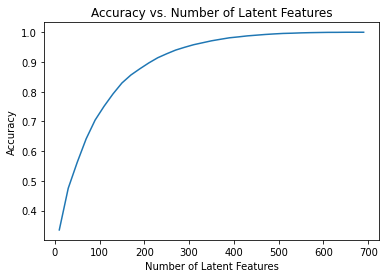

In [133]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [134]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [135]:
# Only 20 users from the test set are in the train set and for which we can predict w/ svd
user_item_train[user_item_train.index.isin(test_idx)].shape[0]

20

In [136]:
#662 for which we cannot
len(test_idx)-20

662

In [137]:
# 574 articles from the test match the train
user_item_train.columns.isin(test_arts).sum()

574

In [138]:
len(test_arts)

574

In [139]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [149]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# All user ids and article ids in the `user_item_train` matrix
train_user_ids = user_item_train.index.values
train_art_ids = user_item_train.columns.values

# Users and articles in both training and test set
common_user_ids_set = np.intersect1d(test_idx, train_user_ids)
common_art_ids_set = np.intersect1d(test_arts, train_art_ids)

# In the `user_item_train` matrix what are the positions of those common elements?
# in1d returns a boolean array the same length as ar1 that is True where an element of ar1 is in ar2 and False otherwise.
train_user_idxs = np.where(np.in1d(train_user_ids, common_user_ids_set))[0]
train_art_idxs = np.where(np.in1d(train_art_ids, common_art_ids_set))[0]

# ...and in the test matrix what are the positions?
test_user_idxs = np.where(np.in1d(test_idx, common_user_ids_set))[0]
test_art_idxs = np.where(np.in1d(test_arts, common_art_ids_set))[0]

In [150]:
user_item_test = user_item_test.iloc[test_user_idxs, test_art_idxs]

In [151]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [152]:
# On the test set filter down to just the users and articles that we can possibly make predictions for (this could pair a user with a different article than in the train set still)
u_test, s_test, vt_test = u_train[train_user_idxs, :], s_train, vt_train[:, train_art_idxs]

In [153]:
latent_feats = np.arange(10,570,10)
sum_train_errors = []
sum_test_errors = []

for k in latent_feats:
    
    # Using just k latent features of the training matrices
    u_train_k, s_train_k, vt_train_k = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    
    # Using just k latent featuires of the test matrices
    u_test_k, s_test_k, vt_test_k = u_test[:, :k], np.diag(s_test[:k]), vt_test[:k, :]
    
    # Calculate dot product
    user_item_train_pred = np.around(np.dot(np.dot(u_train_k, s_train_k), vt_train_k))
    user_item_test_pred = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # Error (prediction - actual values)
    train_error = np.subtract(user_item_train, user_item_train_pred)
    test_error = np.subtract(user_item_test, user_item_test_pred)
    
    # Total errors
    total_train_error = np.sum(np.sum(np.abs(train_error)))
    total_test_error = np.sum(np.sum(np.abs(test_error)))
    sum_train_errors.append(total_train_error)
    sum_test_errors.append(total_test_error)

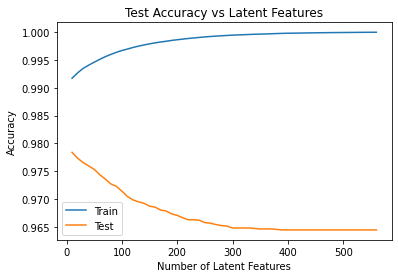

In [155]:
# Plot test accuracy and latent features
n_interactions__train_set = user_item_train.shape[0] * user_item_train.shape[1]
n_interactions__test_set = user_item_test.shape[0] * user_item_test.shape[1]
plt.plot(latent_feats, 1 - np.array(sum_train_errors) / n_interactions__train_set, label='Train');
plt.plot(latent_feats, 1 - np.array(sum_test_errors) / n_interactions__test_set, label='Test');
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');

plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Test Accuracy vs Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

*It seems that on the training set the accuracy gets better and better the more latent features we add, however on the test set the accuracy decreases.*

*However we only have a mere 20 users common between the train and test sets. This is a tiny amount and not likely to be enough to draw conclusions from*

*Instead, we could use an A/B test to measure the effectiveness of a rank based recommendation system against the matrix recommendation system. We would separate users using cookies into equal number groups. Group A would use the rank based recommendations while group B would use the matrix based recommendations. We could use the metric of the percentage of times our recommendations were viewed/interacted with.*


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [157]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0